<h4>
<center> <u>Name:</u> Hitesh Narayana </center><br>
<center> <u>Github username:</u> Hit07 </center><br>
<center> <u>USC ID:</u> 9478372848 </center>
</h4>

## Import Statements

In [1]:
import os
import zipfile
from PIL import Image
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DSCI552_Final_Project')

Mounted at /content/drive


In [3]:
!nvidia-smi 2>&1 | grep -i "cuda"
!nvidia-smi

| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
Sat Dec 14 01:29:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |  

## **b) Data Exploration and Pre-processing**

Images in each class are given in separate folders in the training and test sets. You can encode your classes using one-hot encoding. In case all the images do not have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV.


- We define the class labels for our dataset and extract the images from the zip files for both the training and test datasets. Each class has its own zip file, and the images are extracted into separate directories for each class.
- We create a subplot to visualize a sample image from each class. We also print the number of training and test images for each class. This helps in understanding the distribution of images across different classes.


Buildings:
  Training images: 2191
  Test images: 437
Forest:
  Training images: 2271
  Test images: 474
Glacier:
  Training images: 2404
  Test images: 553
Mountain:
  Training images: 2512
  Test images: 525
Sea:
  Training images: 2274
  Test images: 510
Street:
  Training images: 2382
  Test images: 501


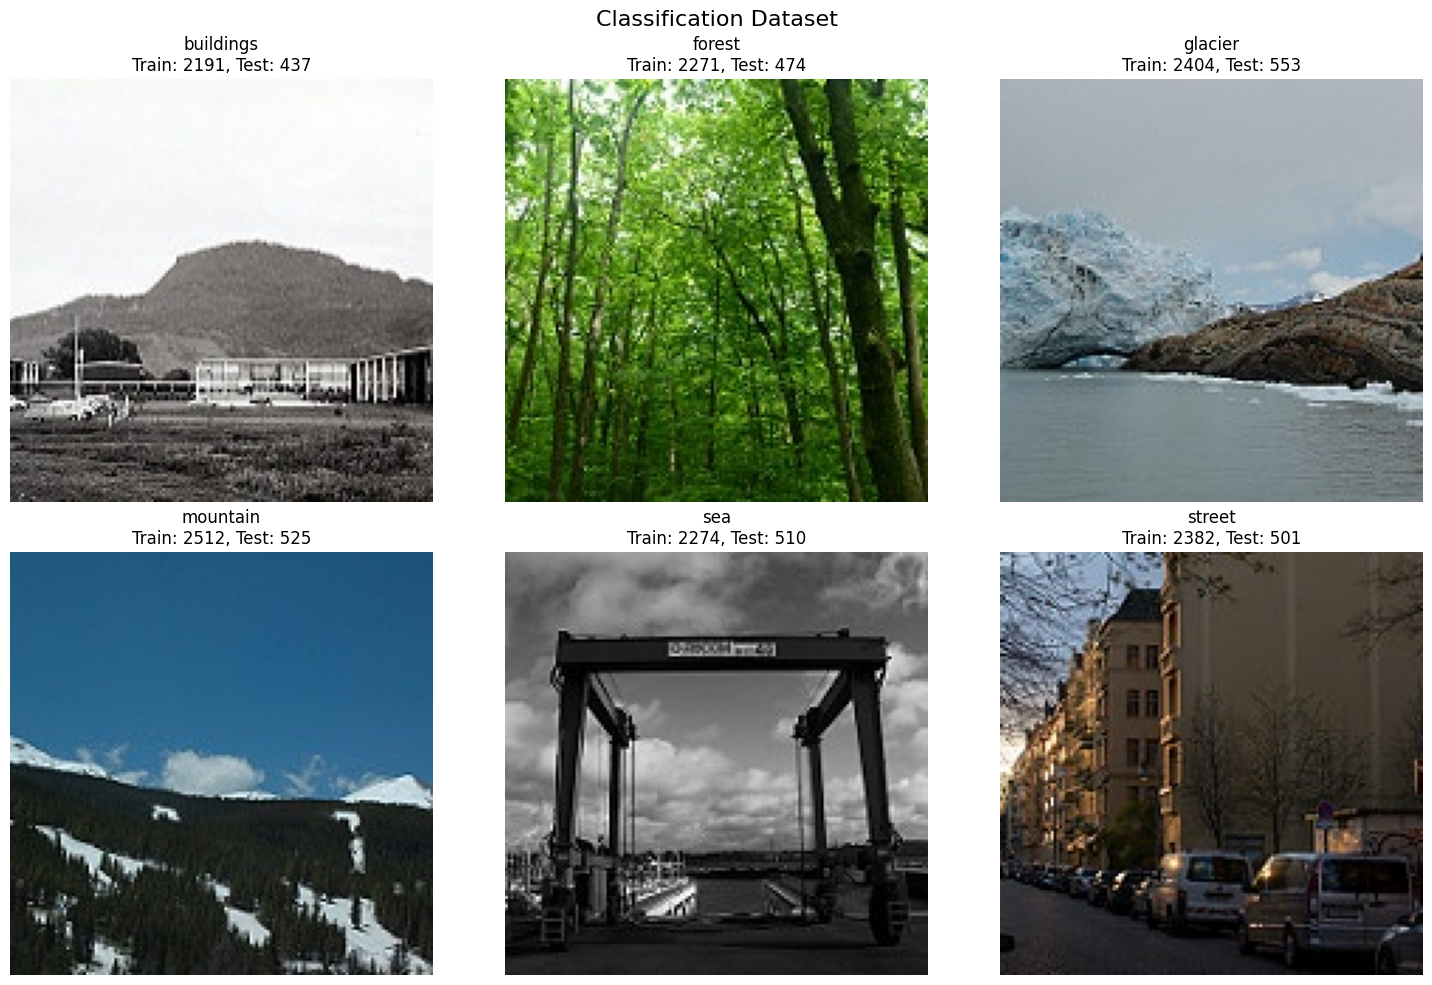

In [4]:
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Extract the data/seg_test zip files and create one-hot encoded class labels
for i, zip_file in enumerate(['buildings.zip', 'forest.zip', 'glacier.zip', 'mountain.zip', 'sea.zip', 'street.zip']):
  with zipfile.ZipFile(os.path.join('seg_test', zip_file), 'r') as zip_ref:
      zip_ref.extractall(os.path.join('data', 'seg_test', str(i)))

# Extract the data/seg_train zip files and create one-hot encoded class labels
for i, zip_file in enumerate(['buildings.zip', 'forest.zip', 'glacier.zip', 'mountain.zip', 'sea.zip', 'street.zip']):
  with zipfile.ZipFile(os.path.join('seg_train', zip_file), 'r') as zip_ref:
      zip_ref.extractall(os.path.join('data', 'seg_train', str(i)))


# Display sample image from each class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Classification Dataset', fontsize=16)
axes_flat = axes.ravel()

for i, (class_name, ax) in enumerate(zip(class_labels, axes_flat)):
  train_dir = os.path.join('data', 'seg_train', str(i))
  test_dir = os.path.join('data', 'seg_test', str(i))
  train_images = len(os.listdir(train_dir))
  test_images = len(os.listdir(test_dir))

  # Number of train and test images
  print(f"{class_name.capitalize()}:")
  print(f"  Training images: {train_images}")
  print(f"  Test images: {test_images}")

  # Display random image for reference
  sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
  sample_image = Image.open(sample_image_path)
  ax.imshow(sample_image)
  ax.set_title(f'{class_name}\nTrain: {train_images}, Test: {test_images}')
  ax.axis('off')

plt.tight_layout()
plt.show()

## c) Transfer Learning

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, con-
trast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV.

#### Data Augmentation

In [6]:
with tf.device('/GPU:0'):

    '''Data augmentation to enhance the training dataset by applying transformations
    such as rotation, zoom, and flipping:'''
    # Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20, # Rotate
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2, # Zoom
        horizontal_flip=True, # Flip
        vertical_flip=False,
        fill_mode="nearest",
        validation_split=0.2 # Validation Split
    )
    val_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)


    '''I'm using batch size of 32 and setting image size to standard 224*224'''
    # Data generators
    train_generator = train_datagen.flow_from_directory(
        "data/seg_train",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        subset="training"
    )

    validation_generator = val_datagen.flow_from_directory(
        "data/seg_train",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
        subset="validation"
    )

    test_generator = test_datagen.flow_from_directory(
        "data/seg_test",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical",
        shuffle=False
    )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [7]:
!nvidia-smi
# Check for GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("CUDA Available:", tf.test.is_built_with_cuda())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

Sat Dec 14 01:31:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              51W / 400W |    423MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

#### Model Creation and Model Architecture
i. When dealing with classification of relatively small image datasets, deep net-
works may not perform very well because of not having enough data to train
them. In such cases, one usually uses transfer learning, which uses deep
learning models that are trained on very large datasets such as ImageNet
as feature extractors. The idea is that such deep networks have learned to
extract meaningful features from an image using their layers, and those fea-
tures can be used in learning other tasks. In order to do that, usually the
last layer or the last few layers of the pre-trained network are removed, and
the response of the layer before the removed layers to the images in the new
dataset is used as a feature vector to train one more multiple replacement lay-
ers. In this project, you will use pre-trained models ResNet50, ResNet100,
EfficientNetB0, and VGG16. For those pre-trained networks, you will only
train the last fully connected layer, and will freeze all layers before them (i.e.
we do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted
from each image.



iii. Use ReLU activation functions in the last layer and a softmax layer, along
with 2 regularization, batch normalization 4, and a dropout rate of 20% as
well as ADAM optimizer. Use multinomial cross entropy loss. You can try
any batch size, but a batch size of 5 seems reasonable.

In [ ]:
# Reference: https://www.tensorflow.org/guide/keras/transfer_learning
def create_model(base_model_class, learning_rate=1e-4):
    base_model = base_model_class(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Using input shape after rescaling to 224*224*3 for color channel RGB
    # Freeze layers expect the last layer
    for layer in base_model.layers:
        layer.trainable = False

    # Building the Model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(), # Average Pooling
        BatchNormalization(momentum=0.9), # BatchNormalization
        Dropout(0.2), # Random dropout to avoid Overfitting
        Dense(256, activation="relu", kernel_regularizer=l2(0.001)), # Using l2 metric to avoid overfitting
        Dense(6, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate), # Custom lr for each model
        loss="categorical_crossentropy", # Categorical data
        metrics=["accuracy"]
    )

    return model

### Model Training

#### Define Custom Callbacks
Find more on it [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)

In [18]:
def get_callbacks(model_name):
    return [
        # Reduce the learning rate when a metric has stopped improving
        ReduceLROnPlateau(
            monitor='val_loss',  # Monitor validation loss
            factor=0.3,          # Factor by which the learning rate will be reduced
            patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
            min_lr=1e-6,
            verbose=1
        ),
        # Stop training when a monitored metric has stopped improving
        EarlyStopping(
            monitor='val_loss',
            patience=7,          # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
            verbose=1
        ),
        # Save the model after every epoch
        ModelCheckpoint(
            filepath=f"{model_name}_best_model_epoch_{{epoch:02d}}.keras",  # Filepath to save the model
            monitor='val_loss',
            mode='min',          # Mode for monitoring the quantity
            save_freq=10,        # Save the model every 10 epochs
            verbose=1
        )
    ]

#### Model Training

vi. Train the networks for at least 50 epochs (preferably 100 epochs) and perform
early stopping using the validation set. Use a randomly selected subset of 20%
of each class as the validation set. Keep the network parameters that have
the lowest validation error. Plot the training and validation errors vs. epochs.


In [19]:
def train_model(model, model_name, train_generator, validation_generator):
    callbacks = get_callbacks(model_name)

    print(f"\n--- Training {model_name} Model ---")
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50, # I'm using 50 epochs
        callbacks=callbacks,
        verbose=1
    )

    return history


### Model Evaluation
These functions are used to evaluate a trained model on a test dataset and to plot the learning curves of the model during training, respectively.


In [20]:
def evaluate_model(model, test_generator, model_name):
    print(f"\n--- Evaluating {model_name} Set ---")
    loss, accuracy = model.evaluate(test_generator, verbose=1)

    # Predict the classes for the test dataset
    y_pred = model.predict(test_generator)
    y_true = test_generator.classes
    y_pred_classes = np.argmax(y_pred, axis=1)

    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    # Calculate AUC for multi-class
    auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred, average='weighted', multi_class='ovr')

    print(f"\nMetrics for {model_name} Set:")
    print(f"Loss: {loss:,.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")


    return loss, accuracy, precision, recall, f1, auc

"""Plot training and validation accuracy and loss curves."""
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### RestNet50



--- Training ResNet50 Model ---
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 164s 433ms/step - accuracy: 0.4192 - loss: 1.7918 - val_accuracy: 0.6277 - val_loss: 1.2224 - learning_rate: 1.0000e-04
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 147s 412ms/step - accuracy: 0.5395 - loss: 1.3630 - val_accuracy: 0.6505 - val_loss: 1.1080 - learning_rate: 1.0000e-04
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 147s 412ms/step - accuracy: 0.5704 - loss: 1.2625 - val_accuracy: 0.6605 - val_loss: 1.0522 - learning_rate: 1.0000e-04
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 147s 411ms/step - accuracy: 0.5902 - loss: 1.2010 - val_accuracy: 0.6694 - val_loss: 1.0285 - learning_rate: 1.0000e-04
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 146s 407ms/step - accuracy: 0.5990 - loss: 1.1670 - val_accuracy: 0.6787 - val_loss: 0.9945 - learning_rate: 1.0000e-04
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 146s 407ms/step - accuracy: 0.5965 - loss: 1.1413 - val_accuracy: 0.6801 - val_loss: 0.9747 - learning_rate: 1.0000e-04
Epoch 7

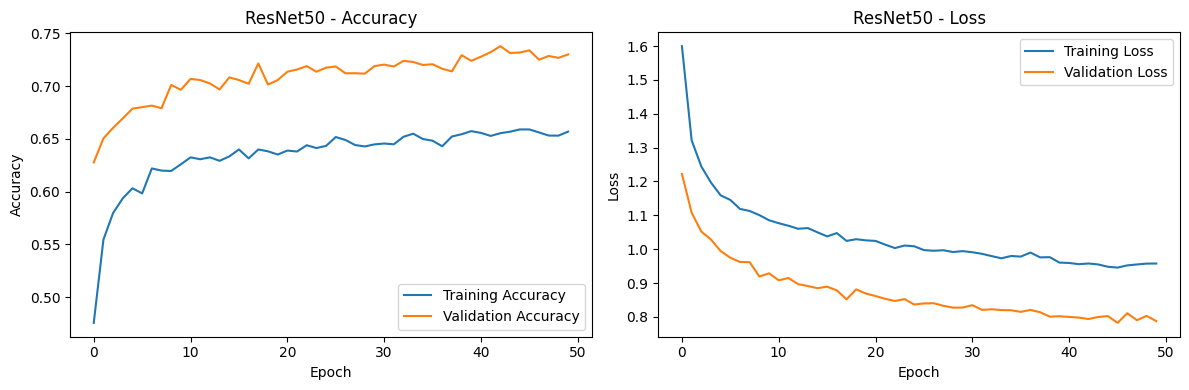

In [17]:
def train_resnet50(train_generator, validation_generator, test_generator):
    tf.keras.backend.clear_session()
    with tf.device('/GPU:0'):
      # Create
      model = create_model(ResNet50, learning_rate=1e-4)
      # Train
      history = train_model(model, "ResNet50", train_generator, validation_generator)
      # Evaluate and plot
      metrics = evaluate_model(model, test_generator, "ResNet50")
      plot_learning_curves(history, "ResNet50")

      return model, history, metrics

resnet50_model, resnet50_history, resnet50_metrics = train_resnet50(train_generator, validation_generator, test_generator)

- The ResNet50 model achieved a validation accuracy of 72.8% and an AUC of 0.944, indicating good performance and generalization. The model's precision, recall, and F1 score are all around 0.73, showing balanced performance across different metrics.

## RestNet101
In my implementation, I opted for ResNet101 instead of ResNet100 since ResNet101 is the standard architecture available in TensorFlow/Keras<br><hr>
Refer for more(https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet)



--- Training ResNet101 Model ---
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 173s 439ms/step - accuracy: 0.4477 - loss: 1.5681 - val_accuracy: 0.6155 - val_loss: 1.0985 - learning_rate: 5.0000e-04
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 146s 407ms/step - accuracy: 0.5489 - loss: 1.2578 - val_accuracy: 0.6298 - val_loss: 1.0641 - learning_rate: 5.0000e-04
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 406ms/step - accuracy: 0.5630 - loss: 1.2088 - val_accuracy: 0.6441 - val_loss: 0.9931 - learning_rate: 5.0000e-04
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 146s 408ms/step - accuracy: 0.5673 - loss: 1.1723 - val_accuracy: 0.6551 - val_loss: 0.9776 - learning_rate: 5.0000e-04
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 406ms/step - accuracy: 0.5880 - loss: 1.1455 - val_accuracy: 0.6530 - val_loss: 0.9850 - learning_rate: 5.0000e-04
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 406ms/step - accuracy: 0.5796 - loss: 1.1319 - val_accuracy: 0.6384 - val_loss: 0.9920 - learning_rate: 5.0000e-04
Epoch 

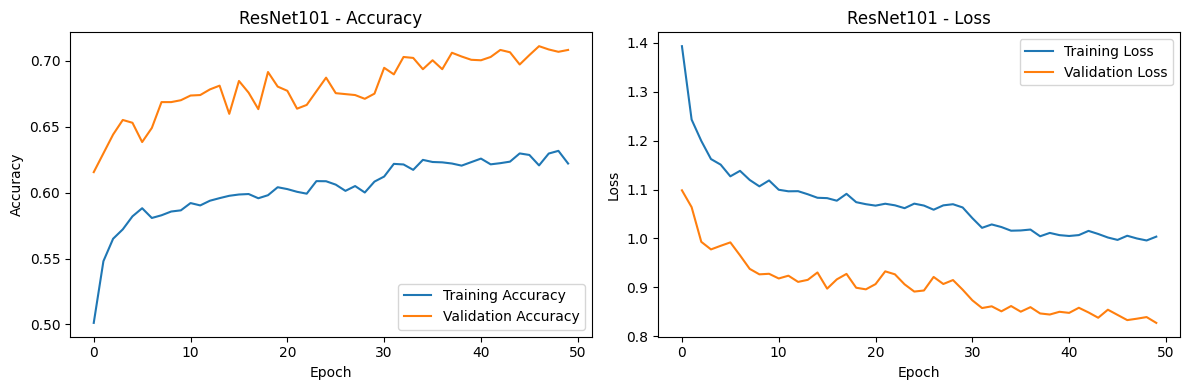

In [24]:
def train_resnet101(train_generator, validation_generator, test_generator):
    tf.keras.backend.clear_session()
    with tf.device('/GPU:0'):
      model = create_model(ResNet101, learning_rate=5e-4)
      history = train_model(model, "ResNet101", train_generator, validation_generator)

      # Evaluate and plot
      metrics = evaluate_model(model, test_generator, "ResNet101")
      plot_learning_curves(history, "ResNet101")

      return model, history, metrics

resnet101_model, resnet101_history, resnet101_metrics = train_resnet101(train_generator, validation_generator, test_generator)

**Inference**:
- The model shows steady learning with validation accuracy reaching ~72%
- There's a consistent gap between training and validation performance
- It seems like the model tends to achieve good accuracy if trained for more epochs

## EfficientnetB0



### Note:
Despite multiple optimization attempts with learning rate adjustments and model tuning, it still ended up with low accuracy and poor performance. I have made some observations which you'll find below

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training EfficientNetB0 Model ---
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 187s 466ms/step - accuracy: 0.1668 - loss: 2.2581 - val_accuracy: 0.1698 - val_loss: 2.1517 - learning_rate: 3.0000e-04
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 404ms/step - accuracy: 0.1804 - loss: 2.1739 - val_accuracy: 0.1690 - val_loss: 2.0787 - learning_rate: 3.0000e-04
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 406ms/step - accuracy: 0.1911 - loss: 2.1002 - val_accuracy: 0.1840 - val_loss: 2.0084 - learning_rate: 3.0000e-04
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 146s 407ms/step - accuracy: 0.1871 - loss: 2.0439 - val_accuracy: 0.1619 - val_loss: 1.9826 - learning_rate: 3.0000e-04
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 406ms/step - accuracy: 0.1944 - loss: 1.9958 - val_accuracy: 0.1698 - val_loss: 1.9524 - learning_rate: 3.0000e-04
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 146s 408ms/step - accuracy: 0.1937 - loss: 1.9534 - val_accuracy: 0.16

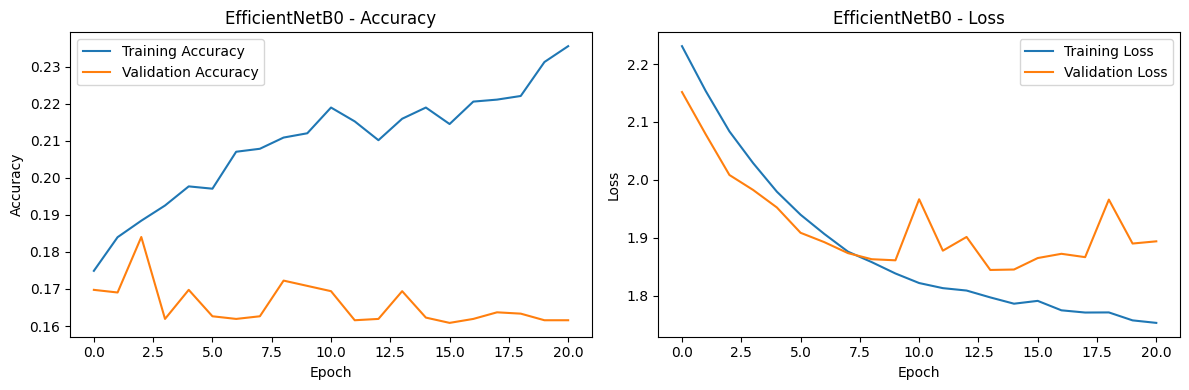

In [25]:
def train_efficientnetb0(train_generator, validation_generator, test_generator):
    tf.keras.backend.clear_session()
    with tf.device('/GPU:0'):
      model = create_model(EfficientNetB0, learning_rate=3e-4)
      history = train_model(model, "EfficientNetB0", train_generator, validation_generator)

      # Evaluate and plot
      metrics = evaluate_model(model, test_generator, "EfficientNetB0")
      plot_learning_curves(history, "EfficientNetB0")

      return model, history, metrics

efficientnetb0_model, efficientnetb0_history, efficientnetb0_metrics = train_efficientnetb0(train_generator, validation_generator, test_generator)

#### **Inference**:
EfficientNetB0 struggled to learn meaningful features for this classification task, suggesting the need for model architecture adjustments, enhanced data preparation, or exploration of alternative models.<br><hr>
Also, I feel the following:
- Significantly lower accuracy (~22%)
- Unstable validation performance
- Signs of overfitting



### VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training VGG16 Model ---
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 156s 421ms/step - accuracy: 0.7151 - loss: 1.0588 - val_accuracy: 0.8502 - val_loss: 0.6469 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 404ms/step - accuracy: 0.8084 - loss: 0.7297 - val_accuracy: 0.8563 - val_loss: 0.5693 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 403ms/step - accuracy: 0.8307 - loss: 0.6272 - val_accuracy: 0.8641 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 402ms/step - accuracy: 0.8231 - loss: 0.6043 - val_accuracy: 0.8723 - val_loss: 0.4894 - learning_rate: 0.0010
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 405ms/step - accuracy: 0.8347 - loss: 0.5579 - val_accuracy: 0.8620 - val_loss: 0.4907 - learning_rate: 0.0010
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 404ms/step - accuracy: 0.8348 - loss: 0.5498 - val_accuracy: 0.8738 - val_loss: 0.4695 - learn

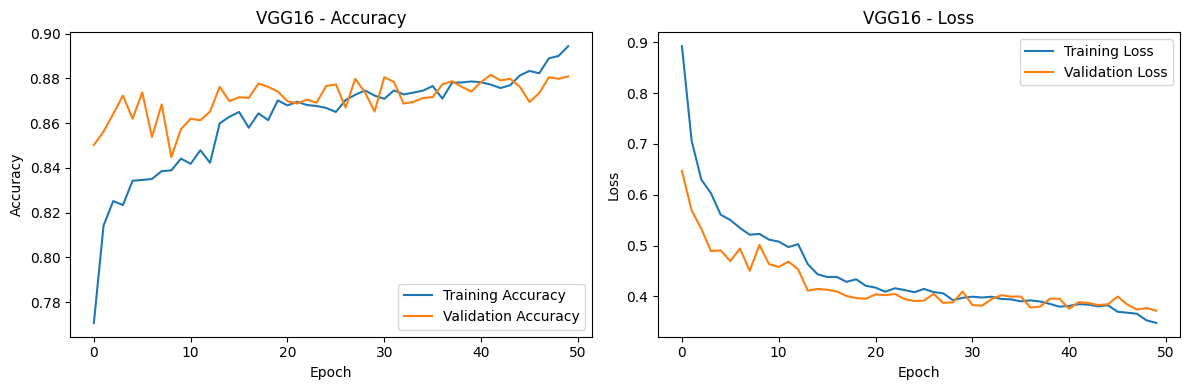

In [26]:
def train_vgg16(train_generator, validation_generator, test_generator):
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    with tf.device('/GPU:0'):
      model = create_model(VGG16, learning_rate=1e-3)
      history = train_model(model, "VGG16", train_generator, validation_generator)

      # Evaluate and plot
      metrics = evaluate_model(model, test_generator, "VGG16")
      plot_learning_curves(history, "VGG16")

      return model, history, metrics

vgg16_model, vgg16_history, vgg16_metrics = train_vgg16(train_generator, validation_generator, test_generator)

<br><hr>
- Training accuracy steadily improves, reaching about 89% by the final epoch, while validation accuracy peaks at around 88%.
- The loss curves show a consistent decrease, with both training and validation loss converging to approximately 0.35–0.40.
- These suggest that VGG16 effectively learns the dataset's features and generalizes well to unseen data.



## Model Comparisions

v. Report training, validation, and test Precision, Recall, AUC, and F1 score for
those models. Is there a model that clearly outperforms others? Remember
that this is a multi-class classification problem.

In [27]:
def compare_models(model_results):
    print("\nModel Comparison:")
    print("Model\t\tPrecision\tRecall\t\tF1 Score\tAUC")
    print("-" * 80)

    results_summary = []
    for model_name, metrics in model_results.items():
        # metrics are: loss, accuracy, precision, recall, f1, auc
        print(f"{model_name:<12}\t{metrics[2]:.4f}\t\t{metrics[3]:.4f}\t\t{metrics[4]:.4f}\t\t{metrics[5]:.4f}")
        results_summary.append({
            'model_name': model_name,
            'precision': metrics[2],
            'recall': metrics[3],
            'f1_score': metrics[4],
            'auc': metrics[5]
        })
    best_model = max(results_summary, key=lambda x: x['f1_score'])
    print(f"\nBest performing model based on F1 Score: {best_model['model_name']}")


model_results = {
    'ResNet50': resnet50_metrics,
    'ResNet101V2': resnet101_metrics,
    'EfficientNetB0': efficientnetb0_metrics,
    'VGG16': vgg16_metrics
}
compare_models(model_results)


Model Comparison:
Model		Precision	Recall		F1 Score	AUC
--------------------------------------------------------------------------------
ResNet50    	0.7306		0.7280		0.7262		0.9441
ResNet101V2 	0.7003		0.6997		0.6979		0.9333
EfficientNetB0	0.0494		0.1673		0.0761		0.7283
VGG16       	0.8863		0.8857		0.8856		0.9881

Best performing model based on F1 Score: VGG16


## **Final Obseravtion**:
The VGG16 model outperformed the other models with the highest F1 Score of 0.8856 and an AUC of 0.9881, indicating excellent performance. ResNet variants also performed well with an F1 Score and AUC. EfficientNetB0 had the lowest performance, with significantly lower precision, recall, and F1 Score. Overall, ```VGG16``` is the best model for this image classification task based on the evaluation metrics.